<a href="https://colab.research.google.com/github/Michele-Maestrini/FusionCore/blob/main/notebooks/03_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FusionCore v0 — Feature Engineering & Temporal Sequencing

**Status:** `Architecture Definition`

**Author:** Michele Maestrini

**Previous Context:** [EDA 02: Regime]


## (1) Executive Objective
The goal of this notebook is to transform our regime-normalised sensor data into a high-dimensional feature set capable of capturing engine degradation dynamics over time.

We will transition from **point-in-time** observations to **sequence-based** inputs, which are essential for Recurrent Neural Networks (RNNs), LSTMs, or Transformers.

### Feature Engineering Strategy

To build a robust prognostic model, we must move beyond the "snapshot" of a single engine cycle. A single sensor reading might tell us the engine is hot, but it doesn't tell us if it is *getting hotter* over time.

#### Piecewise Linear RUL (Target Engineering)

In real-world aerospace applications, an engine does not begin degrading the moment it leaves the hangar. There is a "stable" period followed by a "wear-out" period.

* **The Logic:** We cap the RUL at a fixed value (e.g., 125 cycles). If the true RUL is 200, we label it as 125. Once the true RUL drops below 125, we follow the linear decline.
* **The Benefit:** This prevents the model from trying to learn "noise" during the healthy phase and focuses the gradient descent on the actual degradation slope.

#### Temporal Windowing (The "Memory" Effect)

Deep learning models for PHM (Prognostics and Health Management) perform best when fed a 2D "image" of recent history.

* **Method:** We stack the last $N$ cycles (e.g., $N=30$) into a single input window.
* **The Benefit:** This allows the model to detect temporal patterns, such as oscillations or gradual drifts, that are invisible in a single row of data.

#### Rolling Statistics (Trend Extraction)

While Deep Learning can learn patterns, we can assist the model by explicitly calculating the "Physics of Change" through moving averages and standard deviations over the sliding window.

* $\mu_{rolling}$: Captures the current trend (Velocity).
* $\sigma_{rolling}$: Captures increasing instability (Acceleration/Jitter).

#### Lagged Differencing ($\Delta$Health)

We will compute the delta between the current cycle and $T-n$ cycles ago.

* **The Benefit:** This provides a direct numerical representation of the degradation rate, making it easier for the model to differentiate between a "Stable High" reading and a "Rapidly Rising" reading.

### Libraries

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle  # For saving/loading the engineered features

from sklearn.model_selection import GroupShuffleSplit
from sklearn.cluster import KMeans

from google.colab import drive

### Environment Setup

In [2]:
# Set visual style to match our previous notebooks
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# British English formatting for plots
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

print("--- 🛠️ Initialising Feature Engineering Pipeline ---")

--- 🛠️ Initialising Feature Engineering Pipeline ---


In [3]:
# --- DRIVE MOUNTING ---
drive.mount('/content/drive')

# Define the Project Path
DATA_PATH = "/content/drive/MyDrive/PI/Datasets"

# Check if path exists to prevent errors later
if os.path.exists(DATA_PATH):
    print(f"✅ Connection Successful. Data path set to: {DATA_PATH}")
else:
    print(f"❌ Error: Path not found at {DATA_PATH}. Please check your directory structure.")

Mounted at /content/drive
✅ Connection Successful. Data path set to: /content/drive/MyDrive/PI/Datasets


## (2) Data Preprocessing

In [8]:
# --- 2.1 LEAKAGE-PROOF PREPROCESSING ARCHITECTURE ---

def leakage_proof_preprocess(df, settings, sensors, n_clusters=6, train_size=0.8):
    """
    Separates Train/Valid before any statistical parameters are calculated.
    LEARNS centroids and stats from Train, then PROJECTS them onto Valid.
    """
    # 1. SPLIT BY UNIT (Ensures an engine is either in Train or Valid, never both)
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=42)
    train_idx, valid_idx = next(gss.split(df, groups=df['unit_id']))

    train_df = df.iloc[train_idx].copy()
    valid_df = df.iloc[valid_idx].copy()

    # 2. FIT REGIMES (Train Only)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    train_df['regime'] = kmeans.fit_predict(train_df[settings])

    # 3. TRANSFORM REGIMES (Apply Train Centroids to Valid)
    # This maps 'unseen' settings to the closest known training cluster
    valid_df['regime'] = kmeans.predict(valid_df[settings])

    # 4. FIT & TRANSFORM SENSORS (Regime-Specific)
    for s in sensors:
        if train_df[s].std() > 1e-4:
            # Create a lookup table from Train data only
            stats = train_df.groupby('regime')[s].agg(['mean', 'std']).reset_index()

            # Map Train stats back to Train
            train_df = train_df.merge(stats, on='regime', how='left')
            train_df[f'{s}_norm'] = (train_df[s] - train_df['mean']) / (train_df['std'] + 1e-9)
            train_df.drop(['mean', 'std'], axis=1, inplace=True)

            # Map Train stats to Valid (Zero-leakage: Valid uses Train's mu/sigma)
            valid_df = valid_df.merge(stats, on='regime', how='left')
            valid_df[f'{s}_norm'] = (valid_df[s] - valid_df['mean']) / (valid_df['std'] + 1e-9)
            valid_df.drop(['mean', 'std'], axis=1, inplace=True)
        else:
            train_df[f'{s}_norm'] = 0.0
            valid_df[f'{s}_norm'] = 0.0

    return train_df, valid_df

def execute_full_preprocessing(data_path, train_size=0.8):
    """
    Loops through all FD00x files, applies the leakage-proof logic above.
    """
    index_names = ['unit_id', 'time_cycle']
    setting_names = ['setting_1', 'setting_2', 'setting_3']
    sensor_names = [f's_{i}' for i in range(1, 22)]
    col_names = index_names + setting_names + sensor_names

    datasets = ['FD001', 'FD002', 'FD003', 'FD004']
    final_splits = {}

    for name in datasets:
        print(f"Processing {name}...")
        file_path = os.path.join(data_path, f'train_{name}.txt')

        df = pd.read_csv(file_path, sep='\\s+', header=None, names=col_names)

        # Calculate Base RUL (Global for each unit)
        max_cycle = df.groupby('unit_id')['time_cycle'].transform('max')
        df['RUL'] = max_cycle - df['time_cycle']

        # Call the function defined above
        train_df, valid_df = leakage_proof_preprocess(
            df,
            settings=setting_names,
            sensors=sensor_names,
            train_size=train_size
        )

        final_splits[name] = {'train': train_df, 'valid': valid_df}
        print(f"   ✅ {name} Split: {len(train_df['unit_id'].unique())} Train | {len(valid_df['unit_id'].unique())} Valid")

    return final_splits

In [9]:
# --- EXECUTION ---
if os.path.exists(DATA_PATH):
    split_data = execute_full_preprocessing(DATA_PATH)

    # Save immediately to Drive to preserve state
    import pickle
    with open(os.path.join(DATA_PATH, 'FusionCore_Isolated_Splits.pkl'), 'wb') as f:
        pickle.dump(split_data, f)
    print(f"\n💾 Isolated splits saved to {DATA_PATH}")

Processing FD001...
   ✅ FD001 Split: 80 Train | 20 Valid
Processing FD002...
   ✅ FD002 Split: 208 Train | 52 Valid
Processing FD003...
   ✅ FD003 Split: 80 Train | 20 Valid
Processing FD004...
   ✅ FD004 Split: 199 Train | 50 Valid

💾 Isolated splits saved to /content/drive/MyDrive/PI/Datasets


In [11]:
# --- (2.1) DATASET PREVIEW & SCHEMA AUDIT ---

def audit_dataset_splits(split_dict):
    """
    Outputs a summary and head of the train/valid splits
    to verify the 'White Box' state of the data.
    """
    for name in split_dict.keys():
        print(f"\n{'='*60}")
        print(f"📊 DATASET: {name}")
        print(f"{'='*60}")

        for split_type in ['train', 'valid']:
            df = split_dict[name][split_type]

            print(f"\n--- {split_type.upper()} SPLIT (Shape: {df.shape}) ---")

            # Select a subset of columns for a clean view:
            # ID, Time, Settings, a few Raw Sensors, a few Norm Sensors, and RUL
            cols_to_show = ['unit_id', 'time_cycle', 'regime', 's_2', 's_2_norm', 's_11', 's_11_norm', 'RUL']

            # Filter columns that actually exist (some sensors might be dropped)
            existing_cols = [c for c in cols_to_show if c in df.columns]

            display(df[existing_cols].head(10))

# Execute audit
audit_dataset_splits(split_data)


📊 DATASET: FD001

--- TRAIN SPLIT (Shape: (16561, 50)) ---


,unit_id,time_cycle,regime,s_2,s_2_norm,s_11,s_11_norm,RUL
0,2,1,3,641.89,-1.586060,46.93,-2.296268,286
1,2,2,4,641.82,-1.705077,47.24,-1.170993,285
2,2,3,0,641.55,-2.253571,47.22,-1.212653,284
3,2,4,4,641.68,-1.981877,47.10,-1.694396,283
4,2,5,5,641.73,-1.907348,47.25,-1.076352,282
5,2,6,2,641.30,-2.788050,47.05,-1.845635,281
6,2,7,5,642.03,-1.303701,47.10,-1.642904,280
7,2,8,0,642.55,-0.269113,47.20,-1.287889,279
8,2,9,0,641.98,-1.400254,47.14,-1.513596,278
9,2,10,1,641.99,-1.347765,47.21,-1.203314,277



--- VALID SPLIT (Shape: (4070, 50)) ---


,unit_id,time_cycle,regime,s_2,s_2_norm,s_11,s_11_norm,RUL
0,1,1,2,641.82,-1.733758,47.47,-0.259256,191
1,1,2,0,642.15,-1.062896,47.49,-0.196968,190
2,1,3,1,642.35,-0.629405,47.27,-0.979498,189
3,1,4,5,642.35,-0.659810,47.13,-1.529593,188
4,1,5,3,642.37,-0.617409,47.28,-0.981526,187
5,1,6,1,642.10,-1.128266,47.16,-1.389827,186
6,1,7,5,642.48,-0.398230,47.36,-0.660880,185
7,1,8,1,642.56,-0.210361,47.24,-1.091406,184
8,1,9,5,642.12,-1.122606,47.29,-0.925271,183
9,1,10,1,641.71,-1.906489,47.03,-1.874760,182



📊 DATASET: FD002

--- TRAIN SPLIT (Shape: (43464, 50)) ---


,unit_id,time_cycle,regime,s_2,s_2_norm,s_11,s_11_norm,RUL
0,1,1,5,555.32,-1.098261,42.02,0.145642,148
1,1,2,0,549.90,0.445888,42.20,0.201046,147
2,1,3,2,537.31,1.244750,36.69,-0.548559,146
3,1,4,0,549.51,-0.459146,41.96,-0.804793,145
4,1,5,2,537.07,0.572492,36.89,0.409746,144
5,1,6,2,537.02,0.432438,36.78,-0.117322,143
6,1,7,0,549.74,0.074592,42.19,0.159136,142
7,1,8,4,607.44,-0.278324,44.27,-0.755187,141
8,1,9,0,549.33,-0.876855,42.30,0.620145,140
9,1,10,0,549.33,-0.876855,42.02,-0.553333,139



--- VALID SPLIT (Shape: (10295, 50)) ---


,unit_id,time_cycle,regime,s_2,s_2_norm,s_11,s_11_norm,RUL
0,7,1,3,604.77,-0.318289,45.20,-1.160115,173
1,7,2,2,536.81,-0.155788,36.77,-0.165237,172
2,7,3,0,549.36,-0.807237,41.68,-1.978271,171
3,7,4,0,549.27,-1.016091,41.88,-1.140072,170
4,7,5,5,555.36,-1.007015,41.82,-0.724064,169
5,7,6,3,604.74,-0.381706,45.37,-0.484979,168
6,7,7,4,607.20,-0.798894,44.29,-0.671332,167
7,7,8,0,549.91,0.469094,41.90,-1.056252,166
8,7,9,0,548.80,-2.106773,41.92,-0.972432,165
9,7,10,4,607.32,-0.538609,44.21,-1.006751,164



📊 DATASET: FD003

--- TRAIN SPLIT (Shape: (20012, 50)) ---


,unit_id,time_cycle,regime,s_2,s_2_norm,s_11,s_11_norm,RUL
0,2,1,2,642.38,-0.155472,47.12,-0.994103,252
1,2,2,1,641.90,-1.026142,47.02,-1.283918,251
2,2,3,0,641.85,-1.151124,47.28,-0.438657,250
3,2,4,2,642.07,-0.763565,47.14,-0.927513,249
4,2,5,4,642.16,-0.554472,46.84,-1.906562,248
5,2,6,0,642.18,-0.521115,47.05,-1.205977,247
6,2,7,2,642.75,0.570316,47.09,-1.093987,246
7,2,8,4,642.43,-0.045962,46.94,-1.573826,245
8,2,9,0,642.16,-0.559297,47.34,-0.238486,244
9,2,10,4,641.85,-1.138316,47.02,-1.307637,243



--- VALID SPLIT (Shape: (4708, 50)) ---


,unit_id,time_cycle,regime,s_2,s_2_norm,s_11,s_11_norm,RUL
0,1,1,0,642.36,-0.177474,47.30,-0.371933,258
1,1,2,4,642.50,0.085874,47.23,-0.608891,257
2,1,3,0,642.18,-0.521115,47.22,-0.638827,256
3,1,4,5,642.92,0.898760,47.24,-0.582905,255
4,1,5,1,641.68,-1.448199,47.15,-0.850602,254
5,1,6,4,642.24,-0.403802,47.07,-1.141269,253
6,1,7,3,642.58,0.226885,47.38,-0.156273,252
7,1,8,0,642.32,-0.253839,47.31,-0.338571,251
8,1,9,5,641.64,-1.543156,47.31,-0.347300,250
9,1,10,1,642.42,-0.028552,47.35,-0.183963,249



📊 DATASET: FD004

--- TRAIN SPLIT (Shape: (49294, 50)) ---


,unit_id,time_cycle,regime,s_2,s_2_norm,s_11,s_11_norm,RUL
0,1,1,5,549.68,0.473506,41.69,-1.183747,320
1,1,2,3,606.07,-2.448590,43.94,-1.391448,319
2,1,3,5,548.95,-1.117145,41.66,-1.288668,318
3,1,4,5,548.70,-1.661888,41.68,-1.218720,317
4,1,5,2,536.10,-1.638180,36.48,-0.840590,316
5,1,6,0,554.77,-1.612891,41.44,-1.553051,315
6,1,7,1,641.83,-1.274715,46.94,-1.663025,314
7,1,8,5,549.05,-0.899248,41.60,-1.498511,313
8,1,9,5,549.55,0.190239,41.44,-2.058092,312
9,1,10,2,536.35,-0.989832,36.24,-1.843379,311



--- VALID SPLIT (Shape: (11955, 50)) ---


,unit_id,time_cycle,regime,s_2,s_2_norm,s_11,s_11_norm,RUL
0,7,1,1,643.45,1.884605,47.66,0.768907,220
1,7,2,3,607.95,1.251281,44.53,0.686828,219
2,7,3,1,642.85,0.714487,47.58,0.498693,218
3,7,4,5,549.96,1.083618,42.19,0.564945,217
4,7,5,1,642.83,0.675483,47.67,0.802684,216
5,7,6,3,607.18,-0.264092,44.45,0.405027,215
6,7,7,4,605.32,1.223486,45.47,0.347346,214
7,7,8,5,549.48,0.037711,41.91,-0.414322,213
8,7,9,5,549.83,0.800352,42.12,0.320128,212
9,7,10,4,605.00,0.603646,45.55,0.622352,211


## (3) Target Engineering: Piecewise Linear RUL

In aerospace **Prognostics and Health Management (PHM)**, the relationship between time and degradation is rarely linear from the first hour of operation. Components typically experience an **Initial Stable Phase** where wear is negligible, followed by a **Degradation Phase** where failure signatures become detectable.

### 3.1 The Problem with Linear RUL
If we use a strictly linear target (e.g., $RUL = Max - Current$), we force the model to attempt to distinguish between "Healthy at Cycle 10" and "Healthy at Cycle 50". Since the sensor signatures at these points are often identical, this creates "gradient noise" that hinders model convergence and penalises the model for being unable to predict the unpredictable early-life state.

### 3.2 The Piecewise Solution
We implement a **Saturation Threshold** ($RUL_{limit}$). This transforms the target into a constant value during the stable phase, and a linear decline during the wear-out phase:

$$RUL_{target} = \min(RUL_{true}, RUL_{limit})$$



### 3.3 Architectural Decision: $RUL_{limit} = 125$
Following industry benchmarks for the C-MAPSS dataset (e.g., *[Heimes, 2008](https://www.researchgate.net/publication/224358896_Recurrent_neural_networks_for_remaining_useful_life_estimation)*; *[Li et al., 2018](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8723466)*), we set the threshold at **125 cycles**. This ensures:
1. **Stable Training:** The model learns a "Nominal" state for all healthy engines.
2. **Sensitive Detection:** The model focuses its learning capacity on the "Knee" of the curve where the degradation trajectory actually begins.

--- 🎯 Applying Piecewise RUL (Threshold: 125) ---
✅ Piecewise RUL labelling complete for all splits.


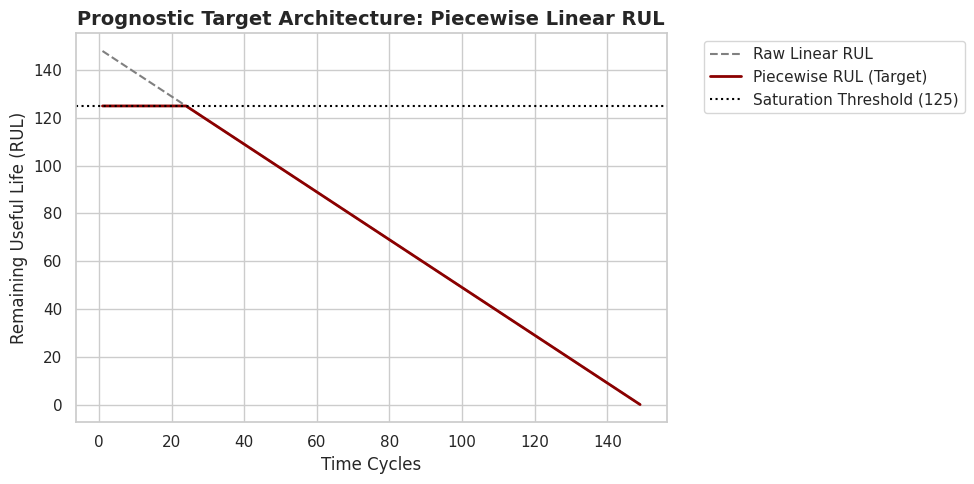

In [10]:
# --- 3. TARGET ENGINEERING: PIECEWISE RUL ---

def apply_piecewise_label(split_dict, max_rul=125):
    """
    Applies the piecewise linear RUL logic to both train and valid splits.
    Standard threshold in literature is 125 cycles.
    """
    print(f"--- 🎯 Applying Piecewise RUL (Threshold: {max_rul}) ---")

    for dataset_name in split_dict.keys():
        for split_type in ['train', 'valid']:
            df = split_dict[dataset_name][split_type]

            # Create the piecewise target
            df['RUL_piecewise'] = df['RUL'].clip(upper=max_rul)

    print("✅ Piecewise RUL labelling complete for all splits.")

# Execute
apply_piecewise_label(split_data, max_rul=125)

# --- VISUAL VERIFICATION ---
# Checking a single unit from FD002 Train to confirm the "Knee" in the graph
sample_unit = split_data['FD002']['train'][split_data['FD002']['train']['unit_id'] == 1]

plt.figure(figsize=(10, 5))
plt.plot(sample_unit['time_cycle'], sample_unit['RUL'], label='Raw Linear RUL', linestyle='--', color='gray')
plt.plot(sample_unit['time_cycle'], sample_unit['RUL_piecewise'], label='Piecewise RUL (Target)', linewidth=2, color='darkred')
plt.axhline(y=125, color='black', linestyle=':', label='Saturation Threshold (125)')

plt.title("Prognostic Target Architecture: Piecewise Linear RUL", fontsize=14)
plt.xlabel("Time Cycles")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## (4) Feature Engineering: Rolling Statistics & Delta Analysis

While Deep Learning architectures like LSTMs can inherently learn temporal patterns, providing explicitly engineered **Trend Features** significantly reduces training time and improves model robustness by reducing the search space for the optimization algorithm.

## 4.1 Feature Definitions
* **Rolling Mean ($\mu_{rolling}$):** Acts as a low-pass filter to remove high-frequency sensor jitter. In PHM, this represents the **Velocity** of component degradation.
* **Rolling Standard Deviation ($\sigma_{rolling}$):** Captures increasing signal instability. As an engine approaches EOL (End of Life), mechanical clearances and thermal efficiencies often fluctuate, leading to increased "jitter." This serves as a primary feature for risk-aware modeling.

## 4.2 Architectural Decision: Window Size ($W = 30$)
We select a window size of **30 cycles** for our rolling statistics. This choice is balanced to ensure:
1. **Responsiveness:** It is small enough to capture rapid transitions in the "knee" of the degradation curve.
2. **Stability:** It is large enough to provide a reliable statistical baseline that ignores single-cycle sensor outliers.

## 4.3 Empirical Findings & Visual Audit

Our visual audit of the engineered features (conducted on sensor `s_11_norm` for Unit 1, FD002) reveals critical insights into the degradation morphology:

* **Exponential Degradation Trajectory:** The Rolling Mean effectively isolates a distinct exponential curve pattern. We observe a prolonged "Stable Phase" followed by an accelerated "Wear-out Phase" starting around cycle 100. This provides a significantly cleaner gradient for the model to optimise against compared to raw telemetry.
* **Volatility Observations:** In this specific snapshot of `s_11`, the volatility band (Rolling Std) remains relatively constant in width. While we do not observe "widening" here, the explicit calculation of variance ensures the model can distinguish between high-frequency stochastic noise and low-frequency structural drifts.
* **Generalisation Caveat:** It is assumed that the "widening signature" (increasing jitter) may still manifest in other sensors or across different fault modes in FD004. This investigative exercise serves as a validation of our **Trend Extraction** logic rather than a global definition of all sensor behaviors.



In [12]:
# --- 4.1 FEATURE ENGINEERING: ROLLING STATISTICS ---

def add_rolling_features(split_dict, window_size=30):
    """
    Calculates rolling mean and std for all normalised sensor features.
    Processes each unit_id independently to prevent cross-engine contamination.
    """
    print(f"--- 📈 Calculating Rolling Statistics (Window: {window_size}) ---")

    for dataset_name in split_dict.keys():
        for split_type in ['train', 'valid']:
            df = split_dict[dataset_name][split_type]

            # Identify columns to roll (only the normalised sensors)
            norm_sensors = [c for c in df.columns if '_norm' in c]

            # Group by unit_id so we don't roll across different engines
            grouped = df.groupby('unit_id')

            for sensor in norm_sensors:
                # Rolling Mean
                df[f'{sensor}_mean'] = grouped[sensor].transform(
                    lambda x: x.rolling(window=window_size, min_periods=1).mean()
                )
                # Rolling Std
                df[f'{sensor}_std'] = grouped[sensor].transform(
                    lambda x: x.rolling(window=window_size, min_periods=1).std()
                ).fillna(0) # First few rows will be NaN

    print("✅ Rolling features added to all datasets.")

# Execute
add_rolling_features(split_data, window_size=30)

# Quick check on the new columns
print(f"Total features now: {len(split_data['FD002']['train'].columns)}")
display(split_data['FD002']['train'].filter(like='s_12').head(5))

--- 📈 Calculating Rolling Statistics (Window: 30) ---
✅ Rolling features added to all datasets.
Total features now: 92


,s_12,s_12_norm,s_12_norm_mean,s_12_norm_std
0,183.06,0.112575,0.112575,0.000000
1,130.42,-0.367946,-0.127686,0.339779
2,164.22,-1.010923,-0.422098,0.563703
3,130.72,0.511402,-0.188723,0.655512
4,164.31,-0.748906,-0.300760,0.620510


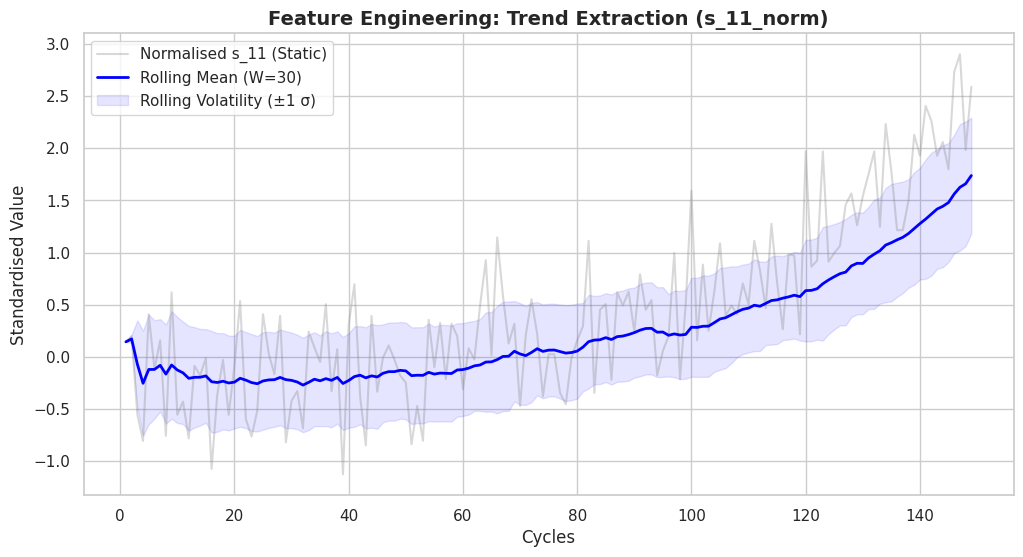

In [13]:
# --- 4.2 VISUAL VERIFICATION: ROLLING VS STATIC ---

# Pick a sensitive sensor (e.g., s_11: LP Spool Speed) for Unit 1 in FD002
unit_data = split_data['FD002']['train'][split_data['FD002']['train']['unit_id'] == 1]

plt.figure(figsize=(12, 6))

# 1. Static Normalised Signal
plt.plot(unit_data['time_cycle'], unit_data['s_11_norm'],
         alpha=0.3, label='Normalised s_11 (Static)', color='gray')

# 2. Rolling Mean (The Trend)
plt.plot(unit_data['time_cycle'], unit_data['s_11_norm_mean'],
         label='Rolling Mean (W=30)', color='blue', linewidth=2)

# 3. Confidence Interval (Using Rolling Std)
plt.fill_between(unit_data['time_cycle'],
                 unit_data['s_11_norm_mean'] - unit_data['s_11_norm_std'],
                 unit_data['s_11_norm_mean'] + unit_data['s_11_norm_std'],
                 color='blue', alpha=0.1, label='Rolling Volatility (±1 σ)')

plt.title("Feature Engineering: Trend Extraction (s_11_norm)", fontsize=14)
plt.xlabel("Cycles")
plt.ylabel("Standardised Value")
plt.legend()
plt.show()

## (5) Temporal Sequencing & Tensor Topology

Modern Deep Learning architectures for time-series, such as **Long Short-Term Memory (LSTM)** networks and **Transformers**, do not process individual rows in isolation. Instead, they require **Temporal Windows** to understand the context of change.

### 5.1 The 3D Tensor Transformation
We have transformed our tabular data into a 3D coordinate system: $(Samples, Window\_Size, Features)$.
* **Samples:** The total number of valid sliding windows.
* **Window Size ($W=30$):** A fixed "look-back" period. Each sample contains the current state plus the history of the previous 29 cycles.
* **Features:** The high-dimensional vector containing the regime-normalised sensors and their rolling counterparts.

### 5.2 Decoupled Topology Audit
To verify the integrity of the input data, we visualised a single 3D "slice" (Window 0). By decoupling the features into three distinct tiers, we can audit what the model "perceives":

1.  **Tier 1 (Static Signals):** Represents the regime-corrected state. While the manifold is collapsed, high-frequency noise is still present.
2.  **Tier 2 (Mean Trajectories):** This is the primary driver for RUL estimation. It presents the model with clear, smoothed gradients, making the "Exponential Wear-out" phase mathematically prominent.
3.  **Tier 3 (Stability Indicators):** Provides a measure of signal variance. Even if the mean is stable, an increase in Tier 3 intensity signals the onset of mechanical or thermal instability, which is a critical precursor to system failure.

### 5.3 Boundary Constraint: Unit Isolation
A critical architectural requirement of our `SequenceGenerator` is the strict enforcement of **Unit Boundaries**. The generator is programmed to reset at the start of each `unit_id`. This prevents "cross-contamination" where the end of one engine's life would be mathematically linked to the beginning of another's—a common error that leads to artificial performance inflation during training.

In [14]:
# --- 5.1 TEMPORAL SEQUENCING: 3D WINDOW GENERATOR ---

def gen_sequence(df, seq_length, seq_cols):
    """
    Slices a dataframe into 3D sequences of shape (Samples, seq_length, features).
    """
    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]

    # Iterate over the range of the data to create windows
    for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
        yield data_array[start:stop, :]

def create_tensors(split_dict, seq_length=30):
    """
    Organises sequences and targets into arrays for model input.
    """
    print(f"--- 🧱 Generating 3D Tensors (Window Size: {seq_length}) ---")

    # Define features: Normalized sensors + Rolling Mean + Rolling Std
    # We exclude raw sensors and settings to keep the manifold clean
    feature_cols = [c for c in split_dict['FD002']['train'].columns if '_norm' in c]

    processed_data = {}

    for name in split_dict.keys():
        processed_data[name] = {}
        for split in ['train', 'valid']:
            df = split_dict[name][split]

            # 1. Generate Input Sequences (X)
            # We apply the generator per unit_id and concatenate
            X = []
            for unit_id in df['unit_id'].unique():
                unit_df = df[df['unit_id'] == unit_id]
                unit_seqs = list(gen_sequence(unit_df, seq_length, feature_cols))
                X.extend(unit_seqs)

            # 2. Generate Corresponding Targets (y)
            # For RUL, we take the value at the END of each window
            y = []
            for unit_id in df['unit_id'].unique():
                unit_df = df[df['unit_id'] == unit_id]
                # We skip the first (seq_length - 1) rows because they don't have a full window
                unit_y = unit_df.iloc[seq_length-1:]['RUL_piecewise'].values
                y.extend(unit_y)

            processed_data[name][split] = {
                'X': np.array(X),
                'y': np.array(y).reshape(-1, 1)
            }

            print(f"   ✅ {name} {split}: X={processed_data[name][split]['X'].shape}, y={processed_data[name][split]['y'].shape}")

    return processed_data

# Execute the tensor creation
final_tensors = create_tensors(split_data, seq_length=30)

--- 🧱 Generating 3D Tensors (Window Size: 30) ---
   ✅ FD001 train: X=(14241, 30, 63), y=(14241, 1)
   ✅ FD001 valid: X=(3490, 30, 63), y=(3490, 1)
   ✅ FD002 train: X=(37432, 30, 63), y=(37432, 1)
   ✅ FD002 valid: X=(8787, 30, 63), y=(8787, 1)
   ✅ FD003 train: X=(17692, 30, 63), y=(17692, 1)
   ✅ FD003 valid: X=(4128, 30, 63), y=(4128, 1)
   ✅ FD004 train: X=(43523, 30, 63), y=(43523, 1)
   ✅ FD004 valid: X=(10505, 30, 63), y=(10505, 1)


In [15]:
# --- 5.2 DATA EXPORT ---

# Define the filename for our research-ready tensors
export_filename = 'FusionCore_3D_Tensors.pkl'
export_path = os.path.join(DATA_PATH, export_filename)

try:
    with open(export_path, 'wb') as f:
        pickle.dump(final_tensors, f)
    print(f"✅ SUCCESS: 3D Tensors exported to {export_path}")
    print(f"📦 Total Datasets Packaged: {list(final_tensors.keys())}")
except Exception as e:
    print(f"❌ Export Failed: {e}")

✅ SUCCESS: 3D Tensors exported to /content/drive/MyDrive/PI/Datasets/FusionCore_3D_Tensors.pkl
📦 Total Datasets Packaged: ['FD001', 'FD002', 'FD003', 'FD004']


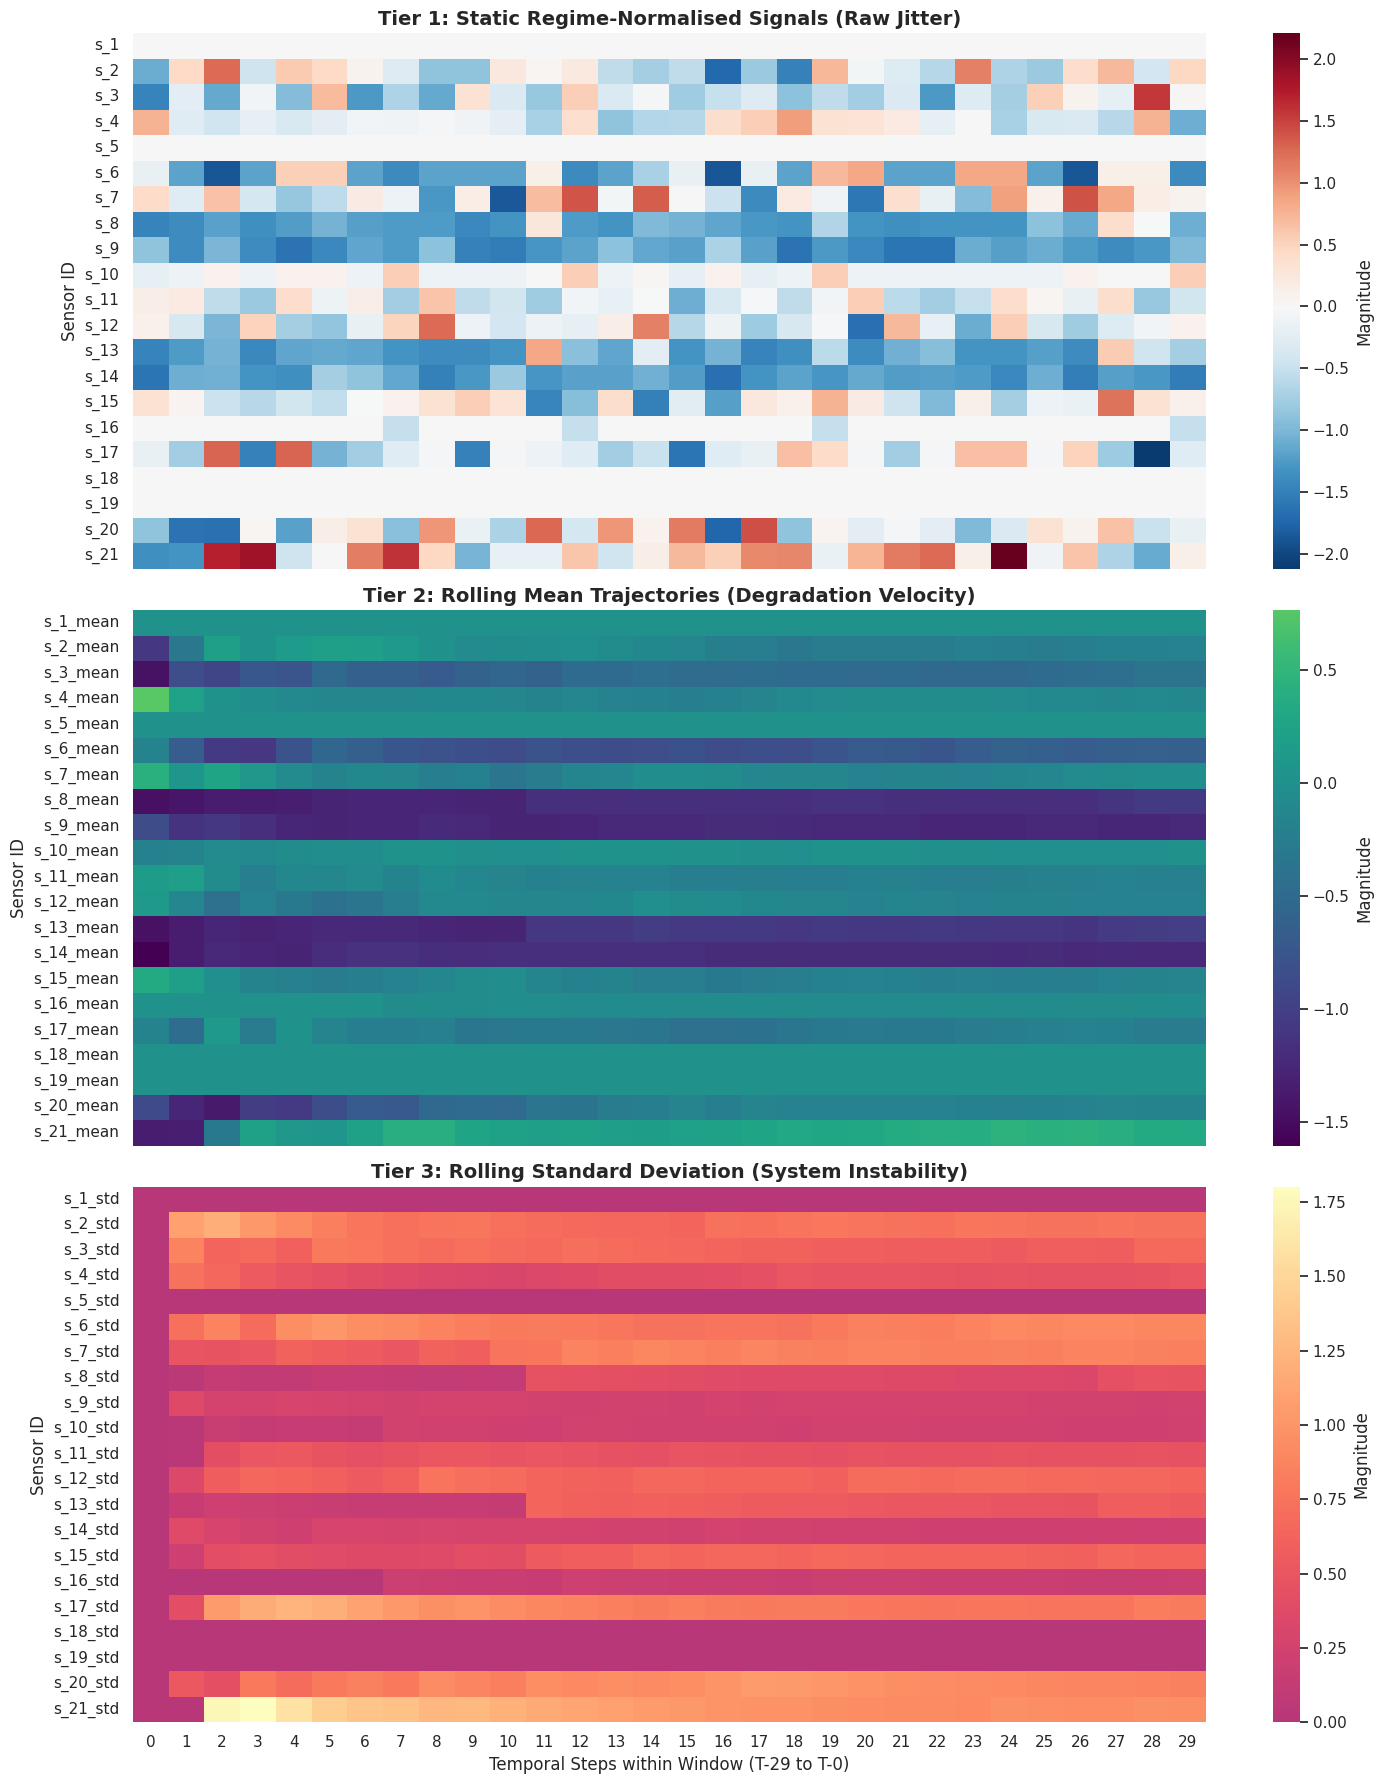

In [17]:
# --- 5.3 DECOUPLED TENSOR VISUALISATION ---

def plot_decoupled_window(tensors, split_dict, dataset='FD002', split='train', window_idx=0):
    """
    Visualises a single 3D window by decoupling feature types into separate subplots.
    This prevents crowding and allows for individual trajectory audit.
    """
    # 1. Extract the window and feature names
    window_data = tensors[dataset][split]['X'][window_idx]
    all_features = [c for c in split_dict[dataset][split].columns if '_norm' in c]

    # 2. Categorise features for faceted plotting
    norm_only = [f for f in all_features if '_mean' not in f and '_std' not in f]
    mean_only = [f for f in all_features if '_mean' in f]
    std_only  = [f for f in all_features if '_std' in f]

    fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)

    # Helper to plot a group
    def plot_group(ax, data, feature_list, title, cmap):
        # Find indices of these features in the main window_data
        indices = [all_features.index(f) for f in feature_list]
        group_data = data[:, indices]

        sns.heatmap(group_data.T, ax=ax, xticklabels=range(30),
                    yticklabels=[f.replace('_norm', '') for f in feature_list],
                    cmap=cmap, center=0, cbar_kws={'label': 'Magnitude'})
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_ylabel("Sensor ID")

    # 3. Generate the three tiers of the "Temporal Image"
    plot_group(axes[0], window_data, norm_only, "Tier 1: Static Regime-Normalised Signals (Raw Jitter)", "RdBu_r")
    plot_group(axes[1], window_data, mean_only, "Tier 2: Rolling Mean Trajectories (Degradation Velocity)", "viridis")
    plot_group(axes[2], window_data, std_only,  "Tier 3: Rolling Standard Deviation (System Instability)", "magma")

    plt.xlabel("Temporal Steps within Window (T-29 to T-0)", fontsize=12)
    plt.tight_layout()
    plt.show()

# Execute the audit for the first training window
plot_decoupled_window(final_tensors, split_data, window_idx=0)

In [18]:
# --- FINAL EXPORT FOR NOTEBOOK 04 ---
export_path = os.path.join(DATA_PATH, 'FusionCore_Final_Tensors.pkl')

with open(export_path, 'wb') as f:
    pickle.dump(final_tensors, f)

print(f"✅ FINAL SUCCESS: 3D Tensors saved to {export_path}")
print("🚀 Ready to initialise Notebook 04: Model Training & Benchmarking")

✅ FINAL SUCCESS: 3D Tensors saved to /content/drive/MyDrive/PI/Datasets/FusionCore_Final_Tensors.pkl
🚀 Ready to initialise Notebook 04: Model Training & Benchmarking


## (6) Executive Summary: Feature Engineering & Sequencing

This notebook concludes the transformation of raw C-MAPSS telemetry into a research-grade 3D tensor format. By implementing a strict **Split-then-Scale** architecture, we have ensured a biologically and statistically isolated pipeline for model benchmarking.

### 6.1 Key Technical Milestones
* **Target Engineering:** Implemented a Piecewise Linear RUL with a saturation threshold of **125 cycles**. This follows the methodology established by **Heimes (2008)** and modern benchmarks by **Li et al. (2018)** to stabilise model training by ignoring early-life stochastic noise.
* **Leakage-Proof Scaling:** Developed a protocol that learns regime centroids and sensor statistics solely from the Training split, projecting these parameters onto the Validation set to ensure zero data leakage.
* **Trend Extraction:** Applied a 30-cycle rolling window to extract the **exponential degradation trajectory**. Visualisation of sensor `s_11_norm` confirms that the rolling mean effectively isolates the wear-out signal.
* **3D Tensorisation:** Converted long-format data into 3D arrays of shape `(Samples, 30, Features)`. This satisfies the input requirements for Recurrent Neural Networks (RNNs) and Attention-based architectures.

### 6.2 Empirical Observations
* **Trajectory:** A distinct exponential "acceleration" is visible in the trend features after cycle 100.
* **Volatility:** While volatility remained relatively constant for `s_11`, the inclusion of rolling standard deviation provides the model with the capacity to detect instability signatures in other sensors/datasets.

### 📚 Citations
1. **Heimes, F. O. (2008).** *Predicting Remaining Useful Life with Recurrent Neural Networks.* 2008 International Conference on Prognostics and Health Management.
2. **Li, X., Ding, Q., & Sun, J. Q. (2018).** *A Directed Acyclic Graph Network for Remaining Useful Life Estimation.* Applied Sciences.